In [2]:
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.stats import ttest_ind
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
from shapely.geometry import Point
from shapely.geometry import shape
from shapely.geometry import box
import os
from glob import glob
import itertools
import cmaps
from scipy.stats.stats import pearsonr
import rasterio
import rioxarray

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

os.chdir('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data')

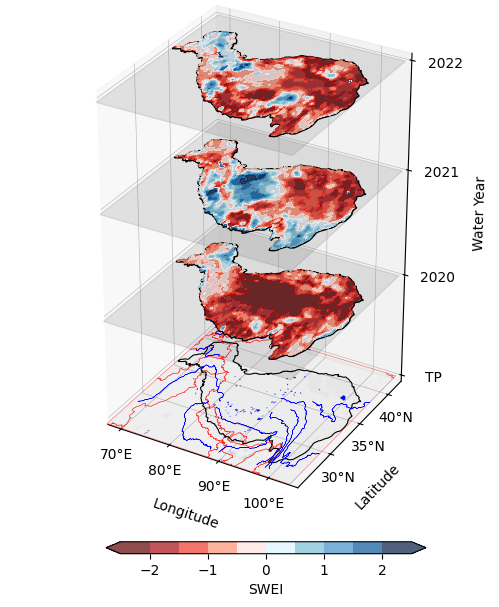

In [5]:
# plot Figure 1-a for SWEI during water year 2020-2022
SWEI_yearly_ERA5 = xr.open_dataarray('SWEI_yearly_ERA5.nc')
TP_shp = gpd.read_file('/Users/zeqinhuang/Documents/dataset/Maps/Tibetan_Plateau/Tibetan_Plateau2.shp')
major_river_shp = gpd.read_file('/Users/zeqinhuang/Documents/dataset/HMA-GIS-Data-main/rivers/TP_river_polygon.shp')
world_country_shp = gpd.read_file('/Users/zeqinhuang/Documents/dataset/HMA-GIS-Data-main/world_shp/国家边界矢量/World_countries.shp')
TP_dem = gpd.read_file('/Users/zeqinhuang/Documents/dataset/HMA-GIS-Data-main/TP_dem_polygon.shp')
concat = lambda iterable: list(itertools.chain.from_iterable(iterable))

fig1a = plt.figure(figsize=(8, 8))
ax3d = fig1a.add_axes([0, 0, 0.6, 1], projection='3d',)
target_projection = ccrs.PlateCarree()

voxels = SWEI_yearly_ERA5.sel(year = slice(2020, 2022))
voxels = voxels.rename({'year':'time','lon':'x','lat':'y'})
voxels = voxels.transpose('x','y','time')
voxels = voxels[:,::-1,:]

def get_feature_polyCollection(geoms, target_projection, bounds=None):
    if bounds == None:
        geoms = [target_projection.project_geometry(geom, target_projection) for geom in geoms]
        paths = concat(geos_to_path(geom) for geom in geoms)
        polys = concat(path.to_polygons() for path in paths)
    else:
        boundary = box(*bounds)
        geoms = [target_projection.project_geometry(geom, target_projection) for geom in geoms]
        geoms = [boundary.intersection(geom) for geom in geoms]
        paths = concat(geos_to_path(geom) for geom in geoms)
        polys = concat(path.to_polygons() for path in paths)
    return polys

for i in range(voxels.shape[2]):
    voxels_i = voxels[:,:,i]
    xi = voxels_i.x
    yi = voxels_i.y
    Xi, Yi = np.meshgrid(xi, yi)
    z0 = voxels_i.squeeze().transpose('y','x')

    levels=np.linspace(-2.5, 2.5, 11)
    p1 = ax3d.contourf(Xi, Yi, z0.values, levels=levels, zdir='z', extend = 'both', offset=i-1, cmap=cmaps.temp_diff_18lev_r,alpha = 0.7)
    # add TP shape
    geoms_TP = TP_shp.geometry
    lc = PolyCollection(get_feature_polyCollection(geoms_TP, target_projection, bounds=(68,24,105,42)), edgecolor='black',facecolor='gray', closed=True,alpha=1)
    ax3d.add_collection3d(lc, zs=i-1)
    
    rec = plt.Rectangle((68,24),width=37,height=18,fc='gray',color='gray',linewidth=1, alpha=0.2)
    ax3d.add_patch(rec)
    art3d.pathpatch_2d_to_3d(rec, z=i-1, zdir='z')
    
# add TP dem to the bottom
geoms_TP_dem = TP_dem.geometry
lc = PolyCollection(get_feature_polyCollection(geoms_TP_dem, target_projection, bounds=(68,24,105,42)), fc=(0,0,0,0.01), ec=(0.25,0.25,0.25,0.05), closed=False, linewidth=0.01)
ax3d.add_collection3d(lc, zs=-2, zdir='z')
# add world country feature
geoms_world = world_country_shp.geometry
lc = PolyCollection(get_feature_polyCollection(geoms_world, target_projection, bounds=(68,24,105,42)), fc=(0,0,0,0.01), ec=(1,0,0,0.6), closed=True, linewidth=0.4)
ax3d.add_collection3d(lc, zs=-2, zdir='z')
# add TP shape
geoms_TP = TP_shp.geometry
lc = PolyCollection(get_feature_polyCollection(geoms_TP, target_projection), fc=(0,0,0,0.01), ec=(0,0,0,1),  closed=True, linewidth=0.8) #edgecolor='black',facecolor=None,
ax3d.add_collection3d(lc, zs=-2, zdir='z')
# add lake feature
feature = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')
geoms = feature.geometries()
lc = PolyCollection(get_feature_polyCollection(geoms, target_projection, bounds=(68,24,105,42)), edgecolor='black',facecolor='blue', closed=True,alpha=1, linewidth=0.02)
ax3d.add_collection3d(lc, zs=-2, zdir='z')
# add major river feature
geoms_river = major_river_shp.geometry
lc = PolyCollection(get_feature_polyCollection(geoms_river, target_projection, bounds=(69,25,106,43)), edgecolor='blue', facecolor='blue', closed=True,alpha=1, linewidth=0.36)
ax3d.add_collection3d(lc, zs=-2, zdir='z')
ax3d.set_xlim(68,105)
ax3d.set_ylim(25,42)

#
ax3d.set_xlabel('Longitude')
ax3d.set_ylabel('Latitude',labelpad=5)
ax3d.set_zlabel('Water Year',rotation=90,labelpad=24)
ax3d.set_xticks([70,80,90,100])
ax3d.set_xticklabels(['70°E','80°E','90°E','100°E'])
ax3d.set_yticks([30,35,40])
ax3d.set_yticklabels(['30°N','35°N','40°N'])
ax3d.tick_params(axis='y', which='major', pad=-50)
ax3d.tick_params(axis='y', which='major', pad=50)
ax3d.tick_params(axis='x', pad=0)
ax3d.tick_params(axis='y', pad=0)
ax3d.tick_params(axis='z', pad=12)
ax3d.set_zlim3d(-2, 1)
ax3d.set_zticks([-2,-1,0,1])
ax3d.set_zticklabels(['TP','2020','2021','2022'],rotation=0)

ax3d.set_box_aspect(aspect=(0.7, 0.7, 1.2))
plt.rcParams['grid.linewidth'] = 0.4
cbar_ax1 = fig1a.add_axes([0.12,0.12,0.4,0.015])
legend1 = fig1a.colorbar(p1, cax=cbar_ax1, shrink=0.7, orientation = 'horizontal')
legend1.ax.set_xlabel('SWEI')
legend1.ax.yaxis.set_label_position('left')
legend1.ax.yaxis.set_tick_params(labelsize=9)
plt.show()
fig1a.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Fig1a_SWEI_3D_2020_2022.png',dpi=300, bbox_inches='tight')
fig1a.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Fig1a_SWEI_3D_2020_2022.pdf', bbox_inches='tight')

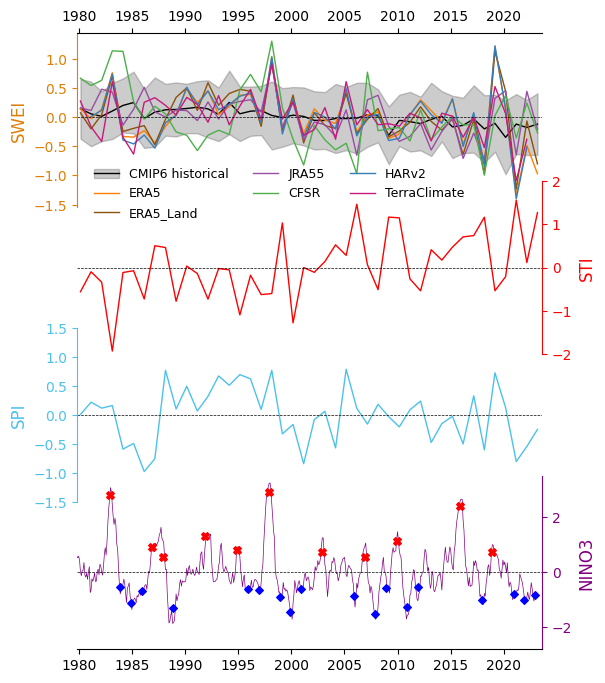

In [4]:
# plot Figure 1-b for temporal change of SWEI SPI and STI during the historical period
# the figure includes 4 subplots, each subplot shows the temporal change of SWEI, SPI, STI and NINO3 index respectively
obs_SWEI_yearly_ts = pd.read_csv('SWEI_year_ts.csv',index_col=0)
obs_SWEI_yearly_ts.index = pd.to_datetime(obs_SWEI_yearly_ts.index)
obs_SPI_yearly_ts = pd.read_csv('ERA5_TP_spi3_yearly_1979_2023.csv',index_col=0)
obs_SPI_yearly_ts = obs_SPI_yearly_ts['SPI3']
obs_SPI_yearly_ts = obs_SPI_yearly_ts[1:]
timeseries = pd.to_datetime(obs_SPI_yearly_ts.index)
obs_STI_yearly_ts = pd.read_csv('ERA5_TP_sti3_yearly_1979_2023.csv',index_col=0)
obs_STI_yearly_ts = obs_STI_yearly_ts['STI3']
obs_STI_yearly_ts = obs_STI_yearly_ts[1:]

NINO3 = pd.read_csv('NINO3.csv', header=None)
NINO3 = NINO3[0].str.split(expand=True)
NINO3 = NINO3.set_index(0)
NINO3 = NINO3.loc['1979':'2022']
NINO3 = NINO3.astype(float)
NINO3 = NINO3.stack()
NINO3.index = pd.date_range(start='1979-01',end='2023-01', freq='M')
NINO3_QS = NINO3.resample('QS-DEC').mean()
NINO3_QS_DJF = NINO3_QS[NINO3_QS.index.month == 12]
NINO3_QS_DJF = NINO3_QS_DJF[1:]

CMIP6_SWEI_hist = pd.read_csv('CMIP6_hist/SWEI_year_ts_all_hist.csv',index_col=0)
CMIP6_SWEI_NAT = pd.read_csv('CMIP6_NAT/SWEI_year_ts_all_NAT.csv',index_col=0)
CMIP6_SWEI_hist.index = pd.date_range(start='1979-01',end='2023-01', freq='Y')
CMIP6_SWEI_NAT.index = pd.date_range(start='1970-01',end='2020-01', freq='Y')
CMIP6_SWEI_hist_mean = CMIP6_SWEI_hist.mean(axis=1)
CMIP6_SWEI_NAT_mean = CMIP6_SWEI_NAT.mean(axis=1)
CMIP6_SWEI_hist_std = CMIP6_SWEI_hist.std(axis=1)
CMIP6_SWEI_NAT_std = CMIP6_SWEI_NAT.std(axis=1)
CMIP6_SWEI_hist_upper = CMIP6_SWEI_hist_mean + CMIP6_SWEI_hist_std
CMIP6_SWEI_hist_lower = CMIP6_SWEI_hist_mean - CMIP6_SWEI_hist_std

fig1b = plt.figure(figsize=(6, 8))

ax1 = fig1b.add_subplot(4, 1, 1)
p0 = ax1.plot(timeseries, CMIP6_SWEI_hist_mean, color='black', label='CMIP6_hist', linewidth=1)
fb = ax1.fill_between(timeseries, CMIP6_SWEI_hist_lower, CMIP6_SWEI_hist_upper, color='black', alpha=0.2)
p1 = ax1.plot(timeseries,obs_SWEI_yearly_ts['ERA5'], color='#ff7f00', label='ERA5', linewidth=1)
p2 = ax1.plot(timeseries,obs_SWEI_yearly_ts['ERA5-Land'], color='#8c510a', label='ERA5_Land', linewidth=1)
p3 = ax1.plot(timeseries,obs_SWEI_yearly_ts['JRA55'], color='#984ea3', label='JRA55', linewidth=1)
p4 = ax1.plot(timeseries,obs_SWEI_yearly_ts['CFSR'], color='#4daf4a', label='CFSR', linewidth=1)
p5 = ax1.plot(timeseries,obs_SWEI_yearly_ts['HARv2'], color='#377eb8', label='HARv2', linewidth=1)
p6 = ax1.plot(timeseries,obs_SWEI_yearly_ts['TerraClimate'], color='#c51b7d', label='TerraClimate', linewidth=1)

# combine p0~p6, and set the legend
lg = [(p0[0],fb), p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]]
ax1.legend(lg, ['CMIP6 historical']+[l.get_label() for l in lg[1:]], ncol=3, loc=[0.025,-0.1], fontsize=9, fancybox=False, frameon=False)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax1.set_ylabel('SWEI', fontsize=12)
ax1.set_xlim(pd.Timestamp('1979-10-31'), pd.Timestamp('2023-07-31'))
ax1.spines[['bottom', 'right']].set_visible(False)
ax1.spines['left'].set_color('#df7f06')
ax1.yaxis.label.set_color('#df7f06')
ax1.tick_params(axis='y', colors='#df7f06')
ax1.tick_params(axis='x', which='both', bottom=False,  top=True, labelbottom=False, labeltop=True)
ax1.xaxis.tick_top()

ax2 = fig1b.add_subplot(4, 1, 2)
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.plot(timeseries, obs_STI_yearly_ts, color='red', label='STI3', linewidth=1)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax2.set_ylabel('STI', fontsize=12)
ax2.set_xlim(pd.Timestamp('1979-10-31'), pd.Timestamp('2023-07-31'))
ax2.set_ylim(-2, 2)
ax2.set(xlabel=None)
ax2.spines[['top','bottom','left']].set_visible(False)
ax2.spines['right'].set_color('red')
ax2.yaxis.label.set_color('red')
ax2.tick_params(axis='y', colors='red')
ax2.tick_params(axis='x', which='both', bottom=False,  top=False, labelbottom=False)

ax3 = fig1b.add_subplot(4, 1, 3)
ax3.plot(timeseries, obs_SPI_yearly_ts, color='#4dc1ec', label='SPI3', linewidth=1)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax3.set_ylabel('SPI', fontsize=12)
ax3.set_xlim(pd.Timestamp('1979-10-31'), pd.Timestamp('2023-07-31'))
ax3.set_ylim(-1.5, 1.5)
ax3.set(xlabel=None)
ax3.spines[['top','bottom','right']].set_visible(False)
ax3.spines['left'].set_color('#4dc1ec')
ax3.yaxis.label.set_color('#4dc1ec')
ax3.tick_params(axis='y', colors='#4dc1ec')
ax3.tick_params(axis='x', which='both', bottom=False,  top=False, labelbottom=False)

ax4 = fig1b.add_subplot(4, 1, 4)
# ax4.plot(NINO3_QS_DJF.index, NINO3_QS_DJF, color='purple', label='NINO3', linewidth=1)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.plot(NINO3.index, NINO3, color='purple', label='NINO3', linewidth=0.5)
ax4.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax4.set_ylabel('NINO3', fontsize=12)
ax4.set_xlim(pd.Timestamp('1979-10-31'), pd.Timestamp('2023-07-31'))
ax4.set_ylim(-2.8, 3.5)
ax4.spines[['top','left']].set_visible(False)
ax4.spines['right'].set_color('purple')
ax4.yaxis.label.set_color('purple')
ax4.tick_params(axis='y', colors='purple')
ax4.tick_params(axis='x', which='both', bottom=True,  top=False, labelbottom=True)
# add EL NINO and LA NINA years with different scatter points to ax4
NINO3_elnino = NINO3_QS_DJF[NINO3_QS_DJF > 0.5]
NINO3_lanina = NINO3_QS_DJF[NINO3_QS_DJF < -0.5]
ax4.scatter(NINO3_elnino.index, NINO3_elnino, color='red', s=30, marker='X', label='El Nino', zorder=5)
ax4.scatter(NINO3_lanina.index, NINO3_lanina, color='blue', s=15, marker='D', label='La Nina', zorder=5)

# set vertical space between subplots
ax1.set_facecolor('none')
ax2.set_facecolor('none')
ax3.set_facecolor('none')
ax4.set_facecolor('none')
plt.subplots_adjust(wspace=0, hspace=-0.15)

# save
fig1b.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Fig1b_SWEI_SPI_STI_NINO3.png',dpi=300, bbox_inches='tight')
fig1b.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Fig1b_SWEI_SPI_STI_NINO3.pdf', bbox_inches='tight')


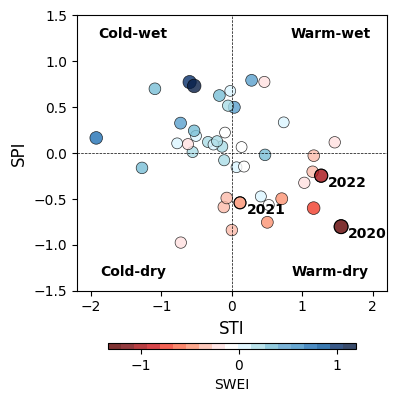

In [4]:
labels = ['Cold-dry','Cold-wet','Warm-dry','Warm-wet']
lables_loc = [(-1.4,-1.3),(-1.4,1.3),(1.4,-1.3),(1.4,1.3)]

fig1c = plt.figure(figsize=(4, 5))
ax1 = fig1c.add_subplot(1, 1, 1)

sc = ax1.scatter(
    obs_STI_yearly_ts, obs_SPI_yearly_ts, c=obs_SWEI_yearly_ts['ERA5'], 
    cmap=cmaps.temp_diff_18lev_r, alpha=0.8, 
    s=np.abs(obs_SWEI_yearly_ts['ERA5'])*30+60, 
    marker='o',
    edgecolor='black', linewidth=0.5)

# label the points with years 2020, 2021, 2022
for i, txt in enumerate(['2020', '2021', '2022']):
    ax1.annotate(txt, (obs_STI_yearly_ts[i-3], obs_SPI_yearly_ts[i-3]), fontsize=10, ha='left', va='top', fontweight='bold', textcoords='offset points', xytext=(5, 0))
    ax1.scatter(obs_STI_yearly_ts[i-3], obs_SPI_yearly_ts[i-3], c='none', edgecolor='black', linewidth=0.8, s=np.abs(obs_SWEI_yearly_ts['ERA5'][i-3])*30+60)

# add text of the labels to the four corners of the plot
for i, txt in enumerate(labels):
    ax1.annotate(txt, lables_loc[i], fontsize=10, ha='center', va='center', fontweight='bold')

ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
ax1.set_xlabel('STI',fontdict={'fontsize':12})
ax1.set_ylabel('SPI',fontdict={'fontsize':12})
ax1.set_xlim(-2.2, 2.2)
ax1.set_ylim(-1.5, 1.5)

# add legend
cbar = plt.colorbar(sc, ax=ax1, orientation='horizontal', pad=0.135, aspect=40, shrink=0.8)
cbar.ax.set_xlabel('SWEI', fontsize=10)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.set_tick_params(labelsize=9)

# save
fig1c.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Fig1c_SPI_STI_SWEI_scatter.png',dpi=300, bbox_inches='tight')
fig1c.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Fig1c_SPI_STI_SWEI_scatter.pdf', bbox_inches='tight')

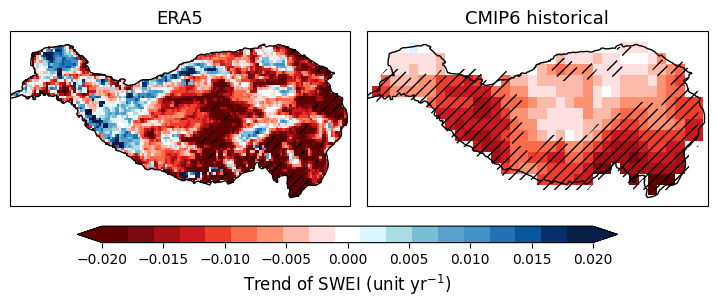

In [5]:
# plot Figure 1-d for the spatial distribution of SWEI trend during the historical period
SWEI_yearly_ERA5_trend = xr.open_dataarray('SWEI_trend_ERA5.nc')
SWEI_yearly_ERA5_trend_pval = xr.open_dataarray('SWEI_trend_pval_ERA5.nc')

SWEI_hist_ensmean_trend = xr.open_dataarray('CMIP6_hist/swei_trend_ensmean_hist.nc')
SWEI_hist_ensmean_trend_sig = xr.open_dataarray('CMIP6_hist/swei_trend_ensmean_sig_hist.nc')

# plot a 1 * 2 subplot, the left subplot shows the trend of SWEI for ERA5, the right subplot shows the trend of SWEI during the historical period
# add the significance of the trend with hatching
fig1d = plt.figure(figsize=(9, 5.5))
fig1d.subplots_adjust(wspace=0.05, hspace=0.3)
ax1 = fig1d.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax2 = fig1d.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

cbar_ax1 = fig1d.add_axes([0.2, 0.27, 0.6, 0.03])

p1 = SWEI_yearly_ERA5_trend.plot(ax=ax1, vmax=0.02, vmin=-0.02, cmap=cmaps.temp_diff_18lev_r, add_colorbar=False)
fig_cbar1 = fig1d.colorbar(p1, cax=cbar_ax1, orientation='horizontal', extend='both')
fig_cbar1.set_label('Trend of SWEI (unit yr$^{-1}$)',fontdict={'fontsize': 12})
SWEI_yearly_ERA5_trend_pval.plot.contourf(ax=ax1, hatches=[None,'///'], levels=[0,0.05], colors='none', alpha=0, add_colorbar=False, extend='both')
ax1.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax1.set_title('ERA5',fontdict={'fontsize': 13, 'fontweight': 'normal'})
# add TP shapefile
TP_shp.plot(ax=ax1, edgecolor='black', facecolor='none')

p2 = SWEI_hist_ensmean_trend.plot(ax=ax2, vmax=0.02, vmin=-0.02, cmap=cmaps.temp_diff_18lev_r, add_colorbar=False)
SWEI_hist_ensmean_trend_sig.plot.contourf(ax=ax2, hatches=[None,'///'], levels=[0,1], colors='none', alpha=0, add_colorbar=False, extend='both')
ax2.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax2.set_title('CMIP6 historical',fontdict={'fontsize': 13, 'fontweight': 'normal'})
# add TP shapefile
TP_shp.plot(ax=ax2, edgecolor='black', facecolor='none')

# save
fig1d.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Fig1d_SWEI_trend_ERA5_CMIP6.png',dpi=300, bbox_inches='tight')
fig1d.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Fig1d_SWEI_trend_ERA5_CMIP6.pdf', bbox_inches='tight')


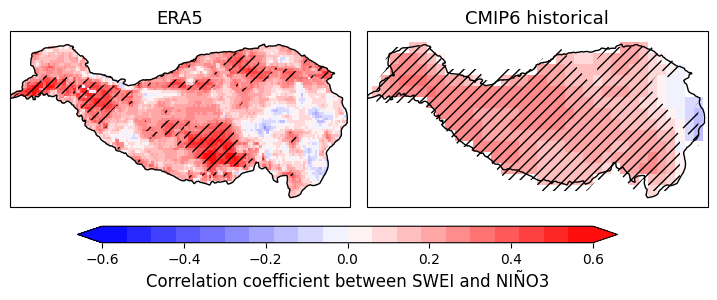

In [6]:
# plot Figure 1-e for the spatial distribution of the correlation between SWEI and NINO3 for ERA5 and during the historical period
SWEI_NINO3_corr_ERA5 = xr.open_dataarray('SWEI_NINO3_corr_ERA5.nc')
SWEI_NINO3_corr_ERA5_pval = xr.open_dataarray('SWEI_NINO3_corr_p_ERA5.nc')

SWEI_NINO3_corr_hist = xr.open_dataarray('CMIP6_hist/SWEI_NINO3_corr_ensmean.nc')
SWEI_NINO3_corr_hist_sig = xr.open_dataarray('CMIP6_hist/SWEI_NINO3_corr_sig.nc')

fig1e = plt.figure(figsize=(9, 5.5))
fig1e.subplots_adjust(wspace=0.05, hspace=0.3)
ax1 = fig1e.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax2 = fig1e.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

cbar_ax1 = fig1e.add_axes([0.2, 0.27, 0.6, 0.03])

p1 = SWEI_NINO3_corr_ERA5.plot(ax=ax1, vmax=0.6, vmin=-0.6, cmap=cmaps.GMT_polar, add_colorbar=False)
fig_cbar1 = fig1e.colorbar(p1, cax=cbar_ax1, orientation='horizontal', extend='both')
fig_cbar1.set_label('Correlation coefficient between SWEI and NIÑO3',fontdict={'fontsize': 12})
SWEI_NINO3_corr_ERA5_pval.plot.contourf(ax=ax1, hatches=[None,'///'], levels=[0,0.05], colors='none', alpha=0, add_colorbar=False, extend='both')
ax1.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax1.set_title('ERA5',fontdict={'fontsize': 13, 'fontweight': 'normal'})
# add TP shapefile
TP_shp.plot(ax=ax1, edgecolor='black', facecolor='none')

p2 = SWEI_NINO3_corr_hist.plot(ax=ax2, vmax=0.6, vmin=-0.6, cmap=cmaps.GMT_polar, add_colorbar=False)
SWEI_NINO3_corr_hist_sig.plot.contourf(ax=ax2, hatches=[None,'///'], levels=[0,1], colors='none', alpha=0, add_colorbar=False, extend='both')
ax2.set_extent([68, 105, 25, 41], crs=ccrs.PlateCarree())
ax2.set_title('CMIP6 historical',fontdict={'fontsize': 13, 'fontweight': 'normal'})
# add TP shapefile
TP_shp.plot(ax=ax2, edgecolor='black', facecolor='none')

# save
fig1e.show()
fig1e.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Fig1e_SWEI_NINO3_corr_ERA5_CMIP6.png',dpi=300, bbox_inches='tight')
fig1e.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/Figures/Fig1e_SWEI_NINO3_corr_ERA5_CMIP6.pdf', bbox_inches='tight')